# Unsupervised clustering of countries based on data from [kaggle](https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data)

# 1. Data Preprossesing

Objective:
To categorise the countries using socio-economic and health factors that determine the overall development of the country.

## 1.1 Loading the Data

In [276]:
import pandas as pd

In [277]:
data = pd.read_csv("Country-data.csv")
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [278]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


* No missing data in the dataset

The Data consists of 167 countries and 9 attributes hereof:
country,Name of the country
child_mort,Death of children under 5 years of age per 1000 live births
exports,Exports of goods and services per capita. Given as %age of the GDP per capita
health,Total health spending per capita. Given as %age of GDP per capita
imports,Imports of goods and services per capita. Given as %age of the GDP per capita
Income,Net income per person
Inflation,The measurement of the annual growth rate of the Total GDP
life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.

# 2. Exploratory Data Analysis (EDA) 

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1 Histograms

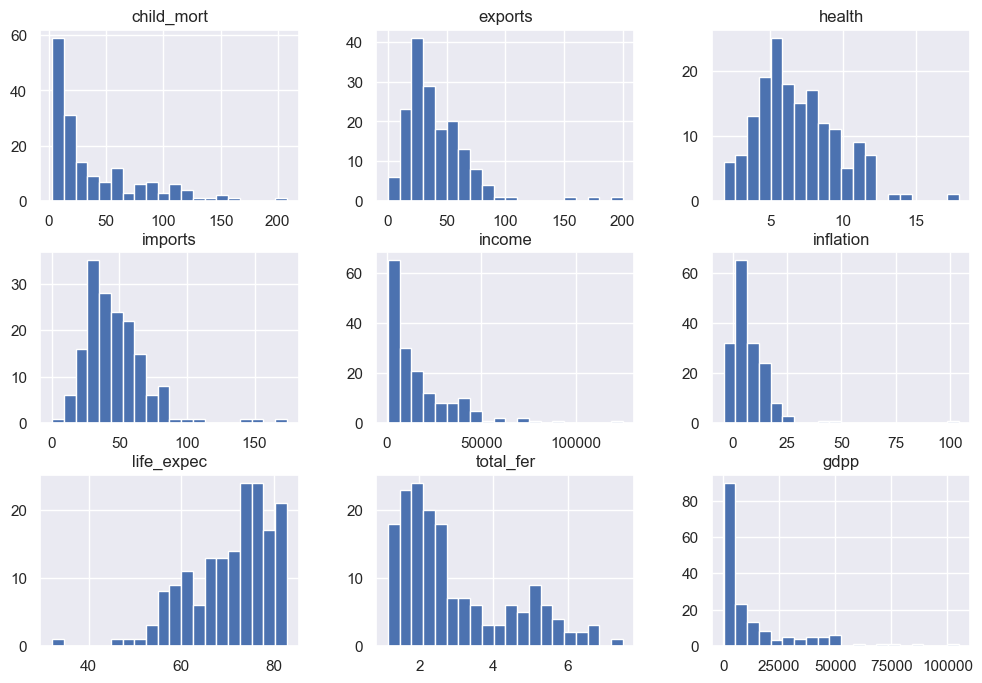

In [280]:
sns.set_theme()
data.hist(figsize=(12,8),bins=20)
plt.show()

* life_expec displays a left or negatively skewed data distribution.
* health displays a normally distrubuted data.
* All the remaining features show a right or positively skewed data distribution. Data distribution of country is not put out as it has text data and it has the same number of unique values as the length of the dataframe.

### 2.2 Correlation matrix

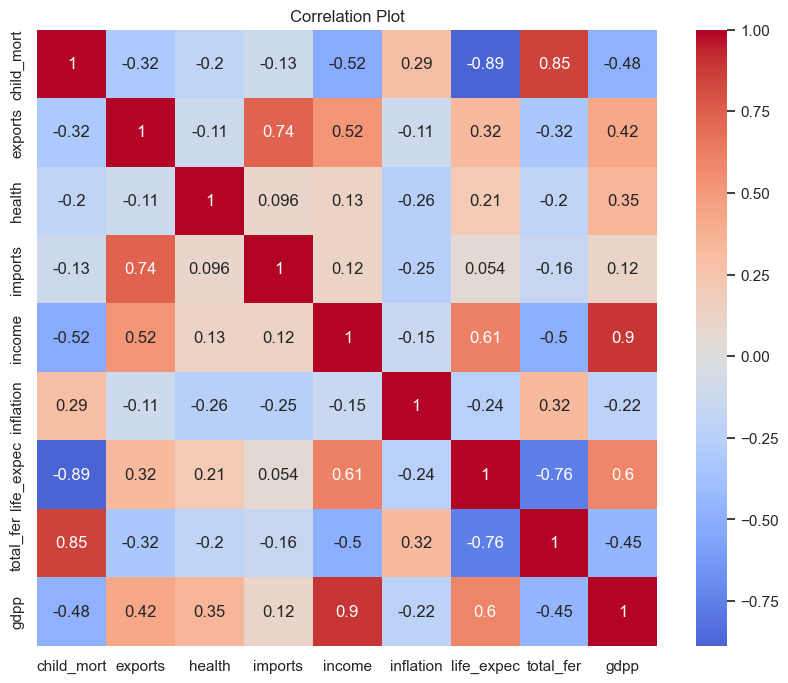

In [281]:
correlation_matrix = data.drop(columns="country").corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Plot")
plt.show()

* Seeing that many attributes are highly correlated, it would be good to do some feature engineering such as combining values or using PCA to reduce the dimension

we see that:

* 'child_mort' is highly correlated with 'income', 'life_expec', 'total_fer' and gdpp
* exports is highly correlated with imports, income and gdpp
* income is highly correlated with c

### 2.3 Boxplots

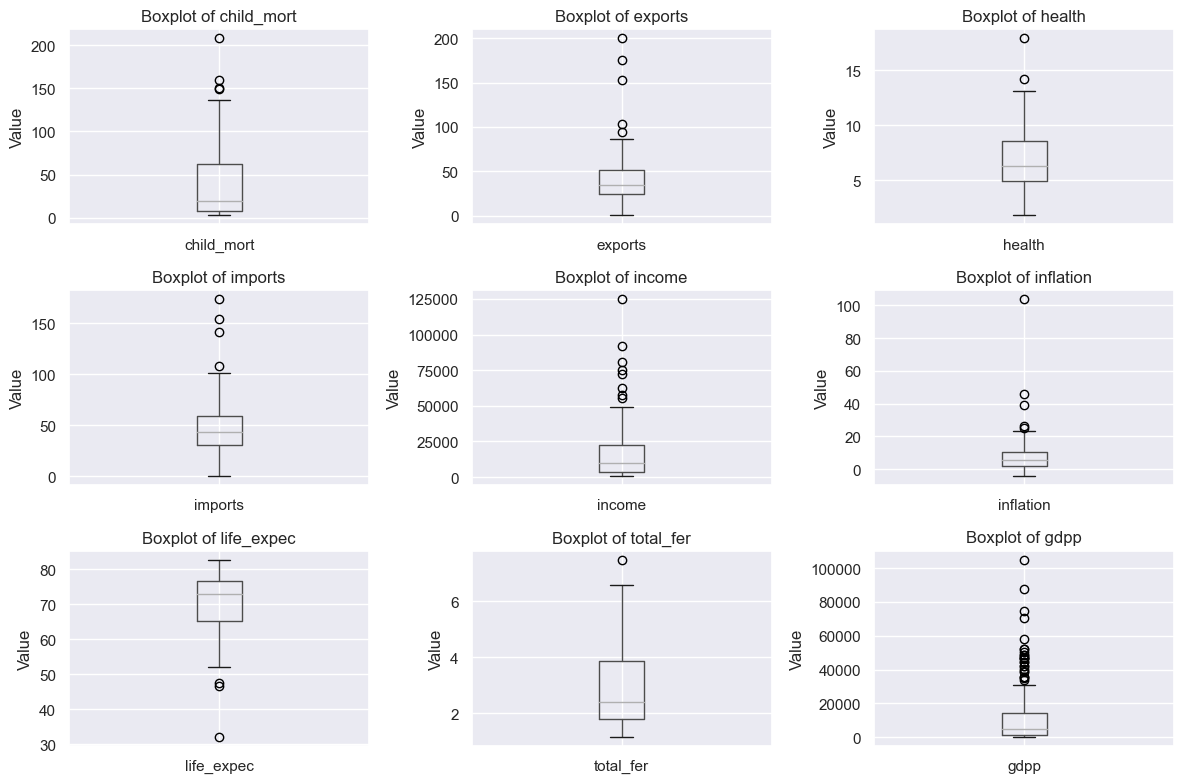

In [253]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))  # Adjust figure size as needed

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()

for i, column in enumerate(data.drop(columns="country").columns):
    data.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f"Boxplot of {column}")
    axes[i].set_ylabel("Value")

# Hide any unused subplots
for j in range(len(data.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [254]:
data[data["inflation"] == data["inflation"].max()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
113,Nigeria,130.0,25.3,5.07,17.4,5150,104.0,60.5,5.84,2330


* Doesn't seem to have any outliers, though some categories such as inflation does have high values but not something impossible

## 3. Feature Engineering

### 3.1 PCA

In [282]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

In [283]:
ss = StandardScaler() # Standardization
X = data.drop(columns="country")
scaled_data = ss.fit_transform(X)

In [284]:
pca = PCA()
data_pca = pca.fit_transform(scaled_data)

# Calculate explained variance ratios
values_pca = pca.explained_variance_
explained_variances = pca.explained_variance_ratio_
cumulative_explained_variances = np.cumsum(explained_variances)
vectors_pca = pca.components_

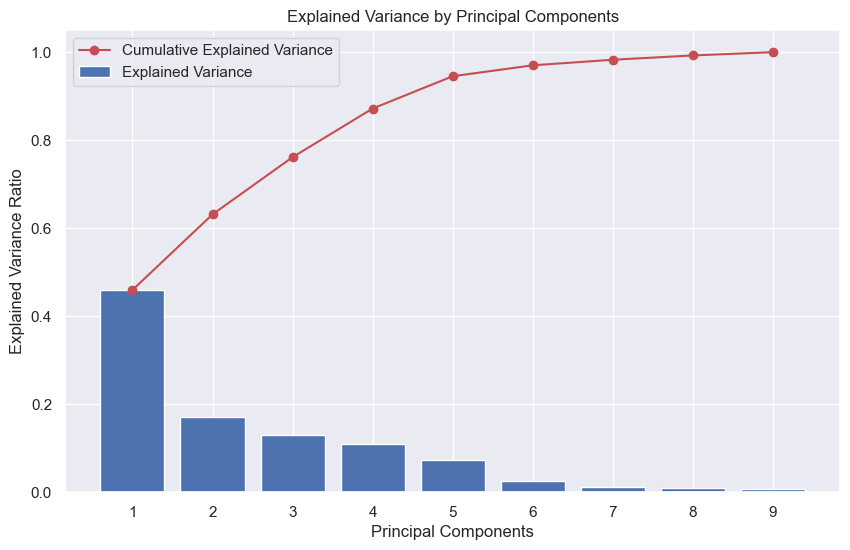

In [285]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variances) + 1), explained_variances, label='Explained Variance')
plt.plot(range(1, len(explained_variances) + 1), cumulative_explained_variances, marker='o', color='r', label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variances) + 1))
plt.legend()
plt.show()

Almost all the variance can be explained by just 4 principal compotents, moving forward we'll be using these 4 components

In [286]:
pca_data = pd.DataFrame(data_pca[:,0:4])

### 3.2 Dealing with the highly correlated features

In [287]:
#bring together exports & imports since these can be expressed as trade
data['trade_balance'] = data['exports'] - data['imports']
#Based on the human index HDI, but without  education
data["HDI"] = np.sqrt(((data["life_expec"]- 20) / 65) * ((np.log(data["gdpp"]) - np.log(100)) / np.log(750) ) )

In [288]:
highly_correlated_features = set()
threshold = 0.8  # This is an example of a threshold, adjust according to your needs

# If the correlation coefficient is above the threshold, add it to the set
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)
highly_correlated_features

{'gdpp', 'life_expec', 'total_fer'}

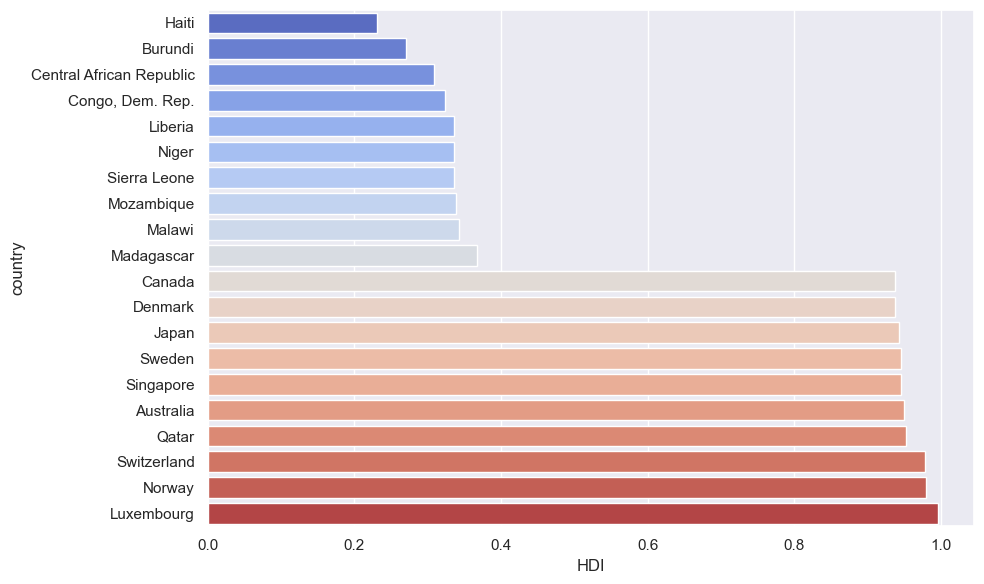

In [289]:
sns.set_theme()
# Sort the DataFrame by 'Value' in ascending order
data_sorted = data.sort_values(by='HDI')

# Get the top 10 and lowest 10 data points
top_10 = data_sorted.tail(10)
lowest_10 = data_sorted.head(10)

# Combine top and lowest data points
selected_data = pd.concat([top_10, lowest_10])

color_palette = sns.color_palette("coolwarm", n_colors=len(selected_data))

plt.figure(figsize=(10, 6))
sns.barplot(data=selected_data.sort_values(by='HDI'), y='country', x='HDI',palette=color_palette)
plt.tight_layout()
plt.show()

In [290]:
data2 = data.drop(columns=["exports","imports","country"])

## 4. Clustering Models

### 4.1 K-means

In [291]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import plotly.express as px                              

### data

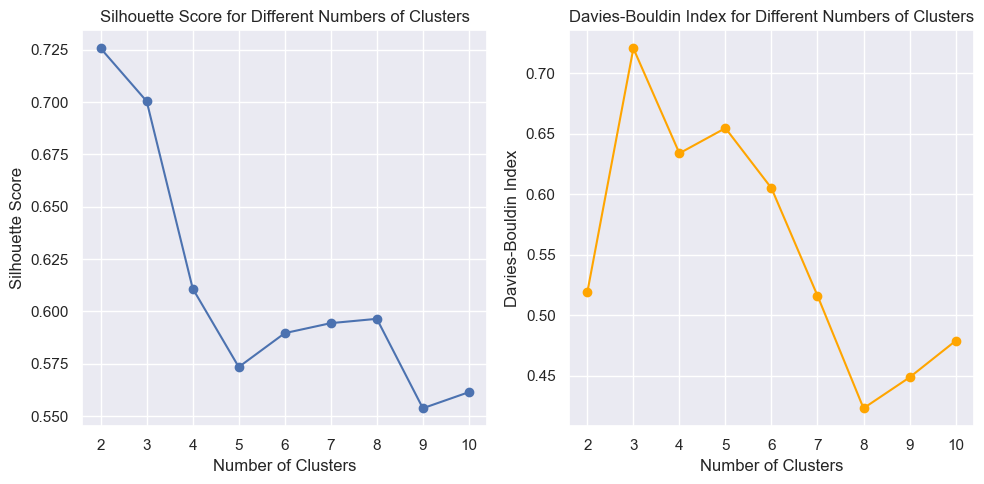

In [292]:
# Range of clusters to test
min_clusters = 2
max_clusters = 10
silhouette_scores = []
davies_bouldin_scores = []

# Loop over different numbers of clusters
for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data2)
    
    silhouette_avg = silhouette_score(data2, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    davies_bouldin_avg = davies_bouldin_score(data2, cluster_labels)
    davies_bouldin_scores.append(davies_bouldin_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(min_clusters, max_clusters + 1))
plt.grid(True)

# Plot Davies-Bouldin scores
plt.subplot(1, 2, 2)
plt.plot(range(min_clusters, max_clusters + 1), davies_bouldin_scores, marker='o', color='orange')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(np.arange(min_clusters, max_clusters + 1))
plt.grid(True)

plt.tight_layout()
plt.show()

In [293]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(data2)

data2["cluster"] = kmeans.labels_
data2["country"] = data["country"]

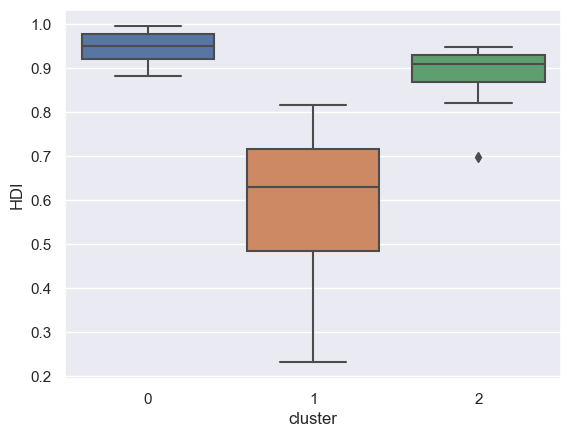

In [294]:
sns.boxplot(data2, x = "cluster",y="HDI")
plt.show()

<Axes: xlabel='cluster', ylabel='income'>

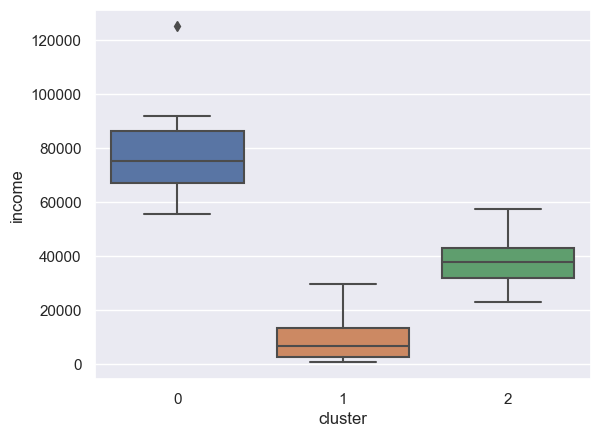

In [295]:
sns.boxplot(data2, x = "cluster",y="income")

In [296]:
data2["cluster"] = data2["cluster"].map({1:"Under Developed",2:"Average Developed",0:"Highly Developed"})

In [297]:
fig = px.choropleth(data2[["country","cluster"]], locationmode = 'country names',locations = "country",color="cluster",
                    color_discrete_map = {'Under Developed':"red",
                                          'Average Developed':"Yellow",
                                          "Highly Developed":"green"})
fig.show()

#### PCA data

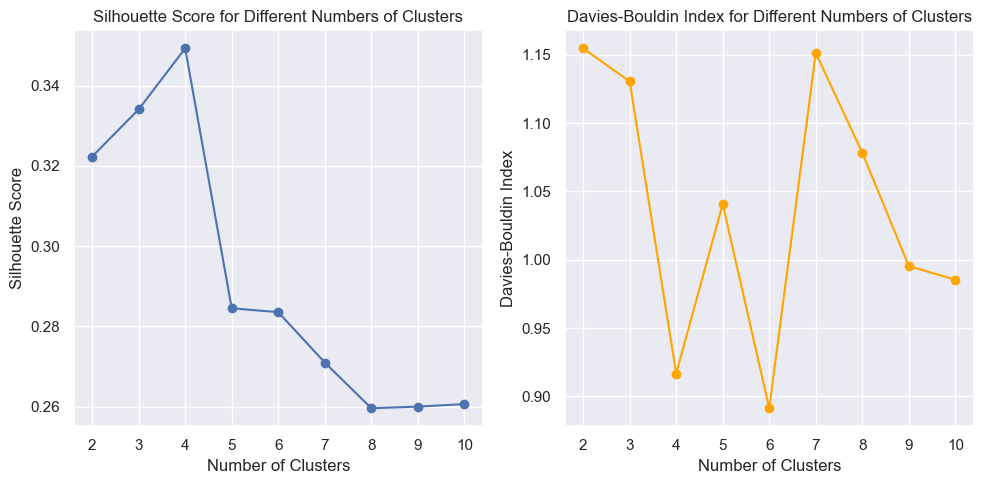

In [298]:
# Range of clusters to test
min_clusters = 2
max_clusters = 10
silhouette_scores = []
davies_bouldin_scores = []

# Loop over different numbers of clusters
for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(pca_data)
    
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    davies_bouldin_avg = davies_bouldin_score(pca_data, cluster_labels)
    davies_bouldin_scores.append(davies_bouldin_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(min_clusters, max_clusters + 1))
plt.grid(True)

# Plot Davies-Bouldin scores
plt.subplot(1, 2, 2)
plt.plot(range(min_clusters, max_clusters + 1), davies_bouldin_scores, marker='o', color='orange')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(np.arange(min_clusters, max_clusters + 1))
plt.grid(True)

plt.tight_layout()
plt.show()

In [299]:
# Create a KMeans instance
kmeans = KMeans(n_clusters=3,n_init=10,random_state=42).fit(pca_data)
pca_data["cluster"] = kmeans.labels_
pca_data["country"] = data["country"]
data["cluster"] = pca_data["cluster"]

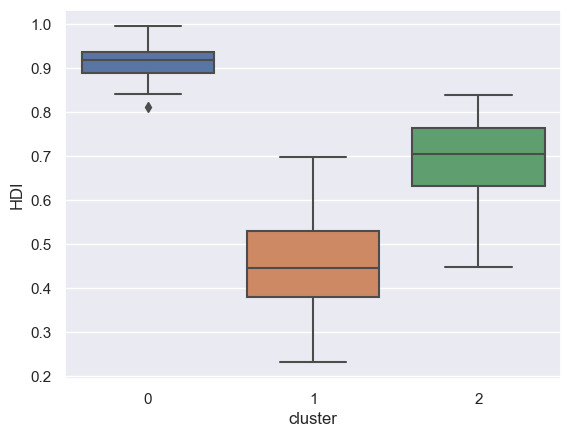

In [300]:
sns.boxplot(data, x = "cluster",y="HDI")
plt.show()

In [301]:
pca_data["cluster"] = pca_data["cluster"].map({1:"Under Developed",2:"Average Developed",0:"Highly Developed"})

In [302]:
fig = px.choropleth(pca_data[["country","cluster"]], locationmode = 'country names',locations = "country",color="cluster",
                    color_discrete_map = {'Under Developed':"red",
                                          'Average Developed':"Yellow",
                                          "Highly Developed":"green"})
fig.show()